## Tutorial

In [1]:
from __future__ import annotations

import getdist as gd
import matplotlib.pyplot as plt
import numpy as np

import mchammers

plt.style.use('light_mode.mplstyle')

### Generate Artificial Data

In [2]:
# set seed for reproducibility
np.random.seed(42)

# true parameter values
m = 1.0
b = 0.5

# number of data points
N = 20

# generate some synthetic data
xdata = np.random.rand(N)
ydata = m*xdata + b + np.random.normal(0, 0.1, N)
yerr  = 0.1
cov   = np.eye(N)*yerr**2 # diagonal covariance matrix for now

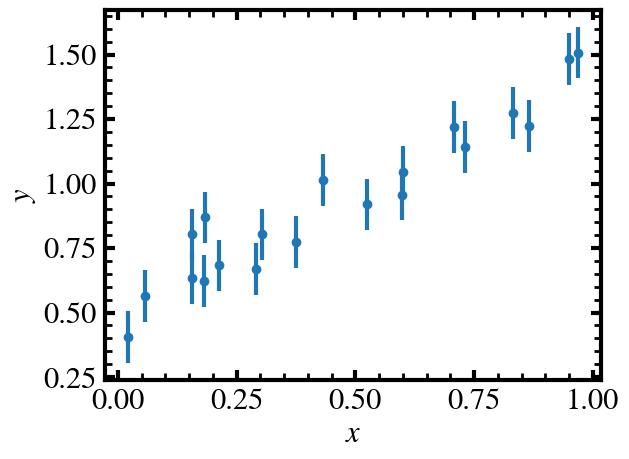

In [3]:
plt.errorbar(xdata, ydata, yerr=yerr, fmt='o')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

### Running the Sampler

In [4]:
# we specify the parameter names, their initial values, and their prior ranges
par_names = ['m', 'b']
par_defaults = [5.0, 0.1]
par_priors   = [(-10,10), (-10,10)]

par_defaults_dict = dict(zip(par_names, par_defaults))
par_priors_dict = dict(zip(par_names, par_priors))

# we write our model function f(x) = mx + b
def model(x, theta):
    """ 
    Theory model for the data.

    Parameters
    ----------
    x : array_like
        The x values at which the model is evaluated.
    theta : shape[num_dims] - array_like 
        The model parameters.

    Returns
    -------
    y : array_like
        The model evaluated at x.
    """
    m, b = theta
    return m*x + b

We define our log probability function which will be fed into the `mchammers.Sampler` class. 

In [5]:
# - - - - - - - - - - - - - - - - - -
#          Log Likelihood
# - - - - - - - - - - - - - - - - - -

def log_likelihood(walker_state, 
                    ydata, xdata, cov,
                    ):
    """ 
    This is the likelihood function for the MCMC sampler

    Arguments:
    -----------------
    walker_state: np.ndarray - shape(num_walkers, num_dims) - the current state of the walker
    ydata: np.ndarray - 1d - measured f(x) values
    xdata: np.ndarray - 1d - measured x values
    cov: np.ndarray - 2d - covariance matrix for errors in ydata

    Returns:
    -----------------
    log_likelihood: np.ndarray - shape(num_walkers, num_dims) - the log likelihood of the walker state
    """

    log_likelihood = np.zeros(walker_state.shape[0])
    for i in range(walker_state.shape[0]):
        μ = model(xdata, walker_state[i])
        diff = ydata - μ 
        log_likelihood[i] = -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

    return log_likelihood

# - - - - - - - - - - - - - - - - - -
#             Log Prior
# - - - - - - - - - - - - - - - - - -

def log_prior(walker_state):
    """
    MCMC samplers require a known prior for sampling
    This is the simplest case of a uniform flat prior

    Arguments:
    -----------------
    walker_state: np.ndarray - shape(num_walkers, num_dims) - the current state of the walker

    Returns:
    -----------------
    log_prior: np.ndarray - shape(num_walkers, num_dims) - the log prior of the walker state
    """

    log_prior = np.zeros(walker_state.shape[0])
    for i in range(walker_state.shape[0]):
        conditions = []
        for j, key in enumerate(par_priors_dict.keys()):
            conditions.append(par_priors_dict[key][0] < walker_state[i][j] < par_priors_dict[key][1])    
        
        if np.all(conditions):
            log_prior[i] = 0.0
        else:
            log_prior[i] = -np.inf

    return log_prior


# - - - - - - - - - - - - - - - - - -
#          Log Probability
# - - - - - - - - - - - - - - - - - -

def log_probability(walker_state, ydata, xdata, cov):
    """
    This is the log probability function for the MCMC sampler

    Arguments:
    -----------------
    walker_state: np.ndarray - shape(num_walkers, num_dims) - the current state of the walker

    Returns:
    -----------------
    log_probability: np.ndarray - shape(num_walkers, num_dims) - the log probability of the walker state
    """

    lp = log_prior(walker_state)    
    return lp + log_likelihood(walker_state, ydata, xdata, cov) 


We first run the basic Metropolis-Hastings MCMC Sampler.

In [15]:
NUM_STEP = 5000
NUM_WALKER = 16
NUM_DIM = len(par_defaults)

#initial state of walkers
initial_state = np.array(par_defaults) + np.random.normal(0, 0.1, (NUM_WALKER, NUM_DIM))

sampler = mchammers.SamplerBasic(
        num_step=NUM_STEP,
        num_walker=NUM_WALKER,
        num_dim=NUM_DIM,
        prior_bounds=par_priors,
        state_init=initial_state,
        log_prob_func=log_probability,
        args=[ydata, xdata, cov],
        std_rel_prop=0.004,
        flatten=False
    )

sampler.run()

We then run the Affine-Invariant Ensemble Sampler

In [16]:
NUM_STEP = 5000
NUM_WALKER = 16
NUM_DIM = len(par_defaults)

#initial state of walkers
initial_state = np.array(par_defaults) + np.random.normal(0, 0.1, (NUM_WALKER, NUM_DIM))

sampler_stretch = mchammers.SamplerStretch(
        num_step=NUM_STEP,
        num_walker=NUM_WALKER,
        num_dim=NUM_DIM,
        prior_bounds=par_priors,
        state_init=initial_state,
        log_prob_func=log_probability,
        args=[ydata, xdata, cov],
        a=2,  # a=2 is implemented in GW10
        frac_burn=0.2,
        flatten=False
    )

sampler_stretch.run()

/Users/jamessunseri/Desktop/APC_524/Final_Project/mchammers/src/mchammers/hammer.py:500: RuntimeWarning: overflow encountered in exp
  q = (self.Z ** (self.num_dim - 1)) * np.exp(log_prob_prop - log_prob_curr)


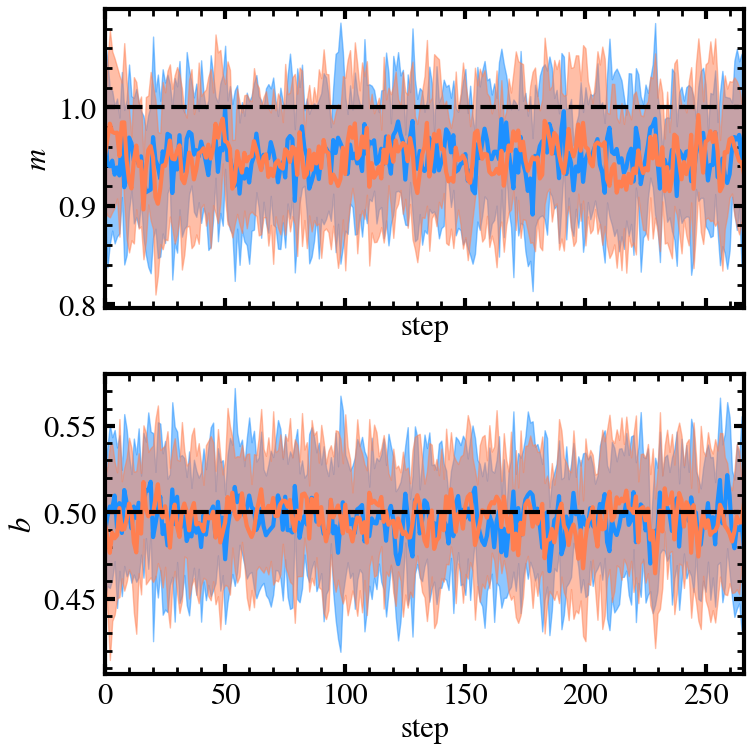

In [36]:
f, axes = plt.subplots(NUM_DIM, 1, figsize=(8, 8), sharex=True)
for i in range(NUM_DIM):
    mean_of_chains = np.mean(sampler.samples[::15, :, i], axis=1)
    std_of_chains = np.std(sampler.samples[::15, :, i], axis=1)
    axes[i].fill_between(range(len(mean_of_chains)), 
                         mean_of_chains - std_of_chains, 
                         mean_of_chains + std_of_chains, 
                         alpha=0.5, color='dodgerblue')
    axes[i].plot(range(len(mean_of_chains)), mean_of_chains, color='dodgerblue')

    mean_of_chains = np.mean(sampler_stretch.samples[::15, :, i], axis=1)
    std_of_chains = np.std(sampler_stretch.samples[::15, :, i], axis=1)
    axes[i].fill_between(range(len(mean_of_chains)), 
                         mean_of_chains - std_of_chains, 
                         mean_of_chains + std_of_chains, 
                         alpha=0.5, color='coral')
    axes[i].plot(range(len(mean_of_chains)), mean_of_chains, color='coral')

    axes[i].axhline([m, b][i], color='k', linestyle='--')
    axes[i].set_ylabel(f"${par_names[i]}$")
    axes[i].set_xlabel("step")
    axes[i].set_xlim(range(len(mean_of_chains))[0], range(len(mean_of_chains))[-1])

plt.tight_layout()


We note that our chains seem to be slightly biased in slope $m$. We are not sure of why this is the case at the moment but with more time we can understand this in the future. Likely due to the way we generated fake data.

### Plot Distribution

In [34]:
samples_base_gd = gd.MCSamples(samples = sampler.samples[::15], # thinning
                          labels = ['m', 'b'],
                            names = ['m', 'b']
)

samples_stretch_gd = gd.MCSamples(samples = sampler_stretch.samples[::15], # thinning
                          labels = ['m', 'b'],
                            names = ['m', 'b']
)

Removed no burn in
Removed no burn in


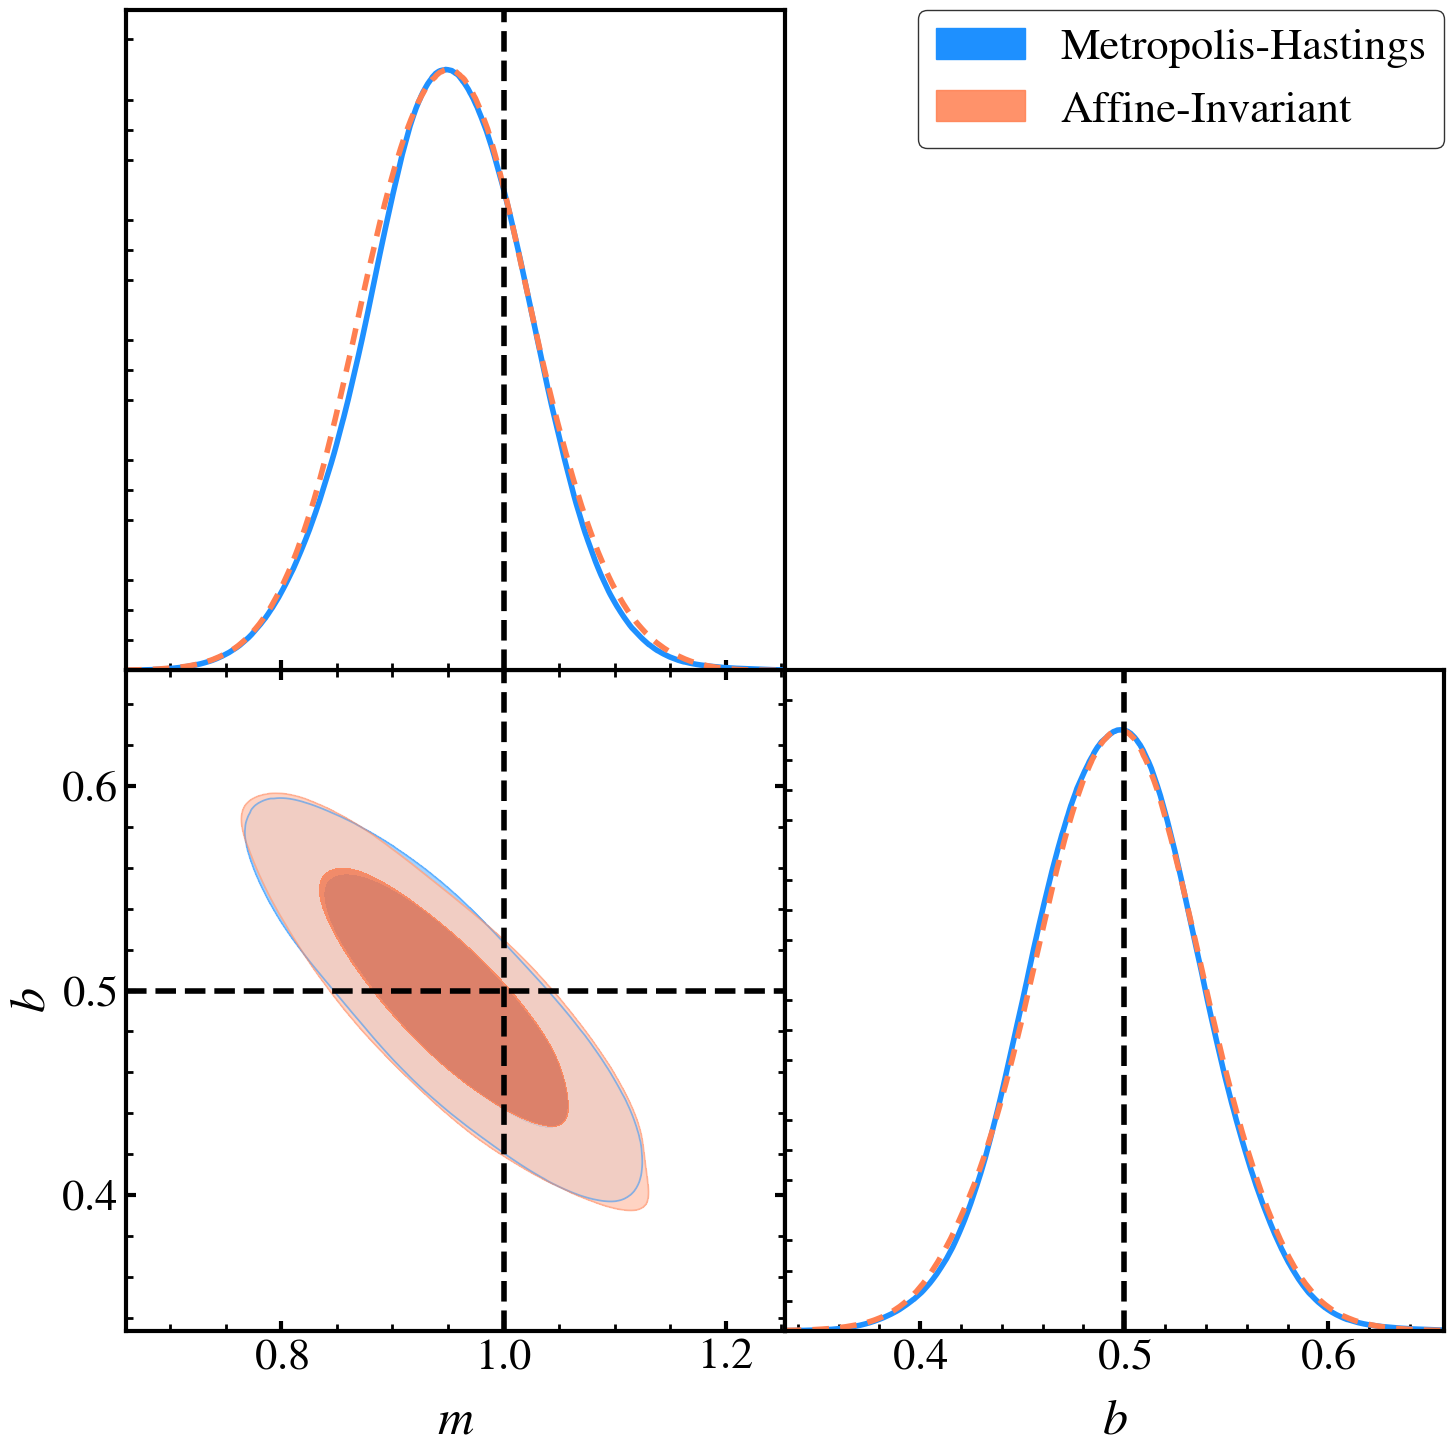

In [35]:
# Triangle plot

width = height = 15
g = gd.plots.get_subplot_plotter(width_inch=width)
g.settings.axes_labelsize = 36 ; g.settings.axes_fontsize = 32 ; g.settings.legend_fontsize = 32


##############################
#        CORNER PLOT
##############################
g.triangle_plot([ 
    samples_base_gd,
    samples_stretch_gd,
], 
contour_colors=[
    'dodgerblue',
    'coral',
],
filled = True,
line_args=[
    {'ls':'-', 'lw':4, 'color':'dodgerblue'},
    {'ls':'--', 'lw':4, 'color':'coral'},
], 
legend_labels=[
    'Metropolis-Hastings',
    'Affine-Invariant',
],
markers={'m':1.0, 'b':0.5}, marker_args={'lw': 4, 'color': 'black'},
)



### Plot with Data

In [44]:
par_means = np.mean(sampler.samples[::15].reshape(-1, NUM_DIM), axis=0)
par_stds = np.std(sampler.samples[::15].reshape(-1, NUM_DIM), axis=0)

print(f"m = {par_means[0]:0.2f} +- {par_stds[0]:0.2f}")
print(f"b = {par_means[1]:0.2f} +- {par_stds[1]:0.2f}")

m = 0.95 +- 0.07
b = 0.50 +- 0.04


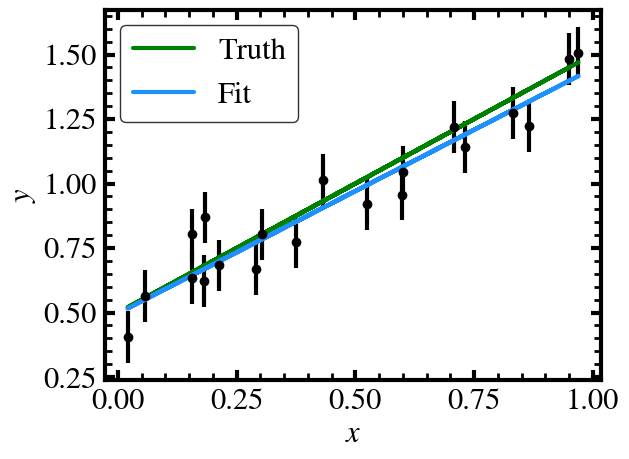

In [49]:
plt.errorbar(xdata, ydata, yerr=yerr, fmt='o', color='k')
plt.plot(xdata, model(xdata, [m, b]), label="Truth", color='green')
plt.plot(xdata, model(xdata, par_means), label="Fit", color='dodgerblue')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()